#### Objective

This notebook shows how to:
- Use Welly to load two wells with GR and RHOB curves
- Store the wells in Pandas DataFrames
- Concatenate in a single Pandas DataFrame 
- Filter curves individually using Bruges mean, and well by well using Pandas groupby 

For reference read [this blog post](https://mycarta.wordpress.com/2018/10/21/geophysics-python-sprint-2018-day-1/).

#### Import libraries

In [1]:
import bruges as br
import numpy as np
import pandas as pd
from welly import Well
import matplotlib.pyplot as plt

#### Import wells

In [2]:
R39 = Well.from_las('../data/R-39.las')

In [3]:
w129 = Well.from_las('../data/P-129_out.las')

#### Data clean-up and manipulation

- Make dataframes
- Deal with null values
- Select columns of interest
- Add well name column
- Concatenate dataframes

Make dataframes

In [4]:
w39_df = R39.df()
w39_df = w39_df[['GR', 'RHOB']]
w39_df.describe()

,GR,RHOB
count,7843.000000,7843.000000
mean,67.490111,2493.556531
std,16.777510,114.662210
min,18.689300,2050.229000
25%,55.299400,2450.387250
50%,72.061800,2505.075000
75%,80.179850,2569.123050
max,191.928200,3144.669700


Checking well R-39 for null values

In [5]:
for x in w39_df.columns:
    print (x, w39_df[x].isnull().values.any())
    
print(w39_df.isnull().sum()) # finds how many missing points there are

GR False
RHOB False
GR      0
RHOB    0
dtype: int64


There are no null values. Let's check P-129

In [6]:
w129_df = w129.df()
w129_df = w129_df[['GR', 'RHOB']]
w129_df.describe()

,GR,RHOB
count,12718.000000,12707.000000
mean,78.986354,2.613912
std,37.071915,0.254185
min,3.894070,1.173953
25%,51.332561,2.526586
50%,76.556969,2.660130
75%,109.833002,2.716321
max,267.940430,4.628800


In [7]:
for x in w129_df.columns:
    print (x, w129_df[x].isnull().values.any())

print(w129_df.isnull().sum()) # finds how many missing points there are

GR False
RHOB True
GR       0
RHOB    11
dtype: int64


It looks like there are some null values in P-129. Below we replace missing values with the mean, then check again

In [8]:
w129_df['RHOB'].fillna(w129_df['RHOB'].mean(),inplace=True)

for x in w129_df.columns:
  print(x, w129_df[x].isnull().values.any())

GR False
RHOB False


Add well name columns

In [9]:
w39_df['DEPTH'] = w39_df.index
name = (['R-39']*len(w39_df))
w39_df['well'] = name
w39_df = w39_df.reset_index(drop=True)
w39_df.describe(include = 'all')

,GR,RHOB,DEPTH,well
count,7843.000000,7843.000000,7843.000000,7843
unique,NaN,NaN,NaN,1
top,NaN,NaN,NaN,R-39
freq,NaN,NaN,NaN,7843
mean,67.490111,2493.556531,2790.596400,NaN
std,16.777510,114.662210,345.067648,NaN
min,18.689300,2050.229000,2193.036000,NaN
25%,55.299400,2450.387250,2491.816200,NaN
50%,72.061800,2505.075000,2790.596400,NaN
75%,80.179850,2569.123050,3089.376600,NaN


In [10]:
w129_df['DEPTH'] = w129_df.index
name = (['P-129']*len(w129_df))
w129_df['well'] = name
w129_df = w129_df.reset_index(drop=True)
w129_df.describe(include = 'all')

,GR,RHOB,DEPTH,well
count,12718.000000,12718.000000,12718.00000,12718
unique,NaN,NaN,NaN,1
top,NaN,NaN,NaN,P-129
freq,NaN,NaN,NaN,12718
mean,78.986354,2.613912,970.10220,NaN
std,37.071915,0.254075,559.53884,NaN
min,3.894070,1.173953,1.06680,NaN
25%,51.332561,2.526682,485.58450,NaN
50%,76.556969,2.660023,970.10220,NaN
75%,109.833002,2.716266,1454.61990,NaN


Concatenate dataframes, sort columns

In [11]:
wells = pd.DataFrame()

for i,df in enumerate([ w129_df, w39_df]):
    wells=wells.append(df)   
wells = wells[['DEPTH', 'GR', 'RHOB', 'well']]    
wells.describe(include = 'all')

,DEPTH,GR,RHOB,well
count,20561.000000,20561.000000,20561.000000,20561
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,P-129
freq,NaN,NaN,NaN,12718
mean,1664.530293,74.601108,952.784768,NaN
std,1010.484213,31.442216,1212.057079,NaN
min,1.066800,3.894070,1.173953,NaN
25%,784.402800,52.915680,2.629247,NaN
50%,1567.738800,73.782000,2.731956,NaN
75%,2604.820800,91.174500,2476.824000,NaN


#### Smooth GR and RHOB curves

##### Logic:
    group dataframe by well

        for each well

            for each of GR, RHOB
    
                smooth using Bruges' median

In [12]:
logs = ['GR', 'RHOB']

In [13]:
window = 5

In [14]:
wells_sm = pd.DataFrame()

grouped = wells['well'].unique()

for well in grouped:    
    new_df = pd.DataFrame()   
    for log in logs:
        sm = br.filters.mean(np.array(wells[log][wells['well'] == well]), window)
        new_df[str(log) + '_sm'] = sm 
    wells_sm = pd.concat([wells_sm, new_df])

Combine DataFrame of smoothed curves with original DataFrame

In [15]:
wells_despiked = (np.concatenate((wells.values, wells_sm.values), axis=1))
cols = list(wells) + list(wells_sm)
wells_despiked_df = pd.DataFrame(wells_despiked, columns=cols)
wells_despiked_df.describe()

,DEPTH,GR,RHOB,well,GR_sm,RHOB_sm
count,20561.0000,20561.000000,20561.00000,20561,20561.000000,20561.00000
unique,20561.0000,17683.000000,19889.00000,2,19912.000000,20023.00000
top,2425.5984,76.556969,2.39882,P-129,76.556969,2.39882
freq,1.0000,278.000000,195.00000,12718,274.000000,177.00000


Make sure results make sense

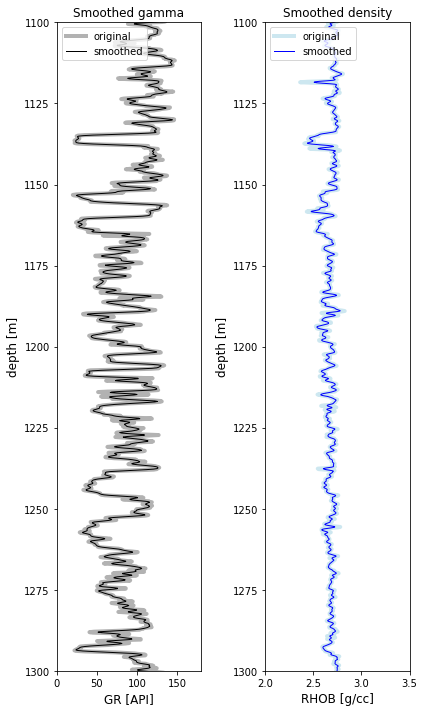

In [16]:
fig = plt.figure(figsize=(6,10))

ax0 = fig.add_subplot(121)
ax0.plot(wells_despiked_df.loc[wells_despiked_df.well == 'P-129', 'GR'], 
         wells_despiked_df.loc[wells_despiked_df.well == 'P-129', 'DEPTH'],
                                 'gray', alpha=0.6, linewidth = 4, label='original')
ax0.plot(wells_despiked_df.loc[wells_despiked_df.well == 'P-129', 'GR_sm'], 
         wells_despiked_df.loc[wells_despiked_df.well == 'P-129', 'DEPTH'],
                                 'k', linewidth = 1, label='smoothed')
ax0.set_xlim([0, 180])
ax0.set_ylim([1100, 1300])
ax0.legend( loc='upper left')
ax0.set_title('Smoothed gamma')
ax0.set_ylabel(r'depth [m]', size=12)
ax0.invert_yaxis()
ax0.set_xlabel(r'GR [API]', size=12)

ax1 = fig.add_subplot(122)
ax1.plot(wells_despiked_df.loc[wells_despiked_df.well == 'P-129', 'RHOB'], 
         wells_despiked_df.loc[wells_despiked_df.well == 'P-129', 'DEPTH'],
                                 'lightblue', alpha=0.6, linewidth = 4, label='original')
ax1.plot(wells_despiked_df.loc[wells_despiked_df.well == 'P-129', 'RHOB_sm'], 
         wells_despiked_df.loc[wells_despiked_df.well == 'P-129', 'DEPTH'],
                                 'b', linewidth = 1, label='smoothed')
ax1.set_xlim([2, 3.5])
ax1.set_ylim([1100, 1300])
ax1.legend( loc='upper left')
ax1.set_title('Smoothed density')
ax1.set_ylabel(r'depth [m]', size=12)
ax1.invert_yaxis()
ax1.set_xlabel(r'RHOB [g/cc]', size=12)

plt.tight_layout()
plt.show()

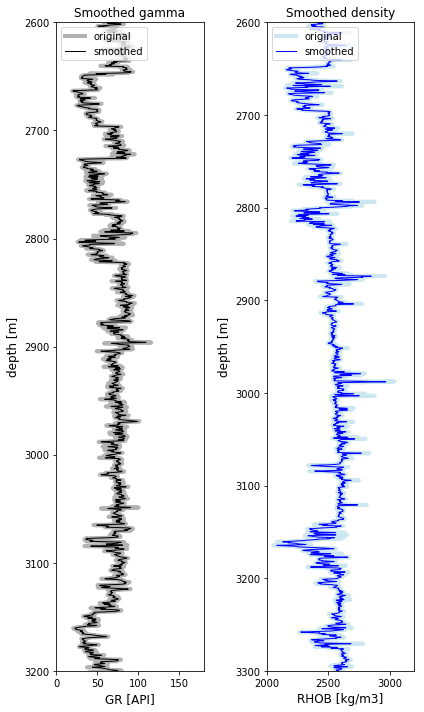

In [17]:
fig = plt.figure(figsize=(6,10))

ax0 = fig.add_subplot(121)
ax0.plot(wells_despiked_df.loc[wells_despiked_df.well == 'R-39', 'GR'], 
         wells_despiked_df.loc[wells_despiked_df.well == 'R-39', 'DEPTH'],
                                 'gray', alpha=0.6, linewidth = 4, label='original')
ax0.plot(wells_despiked_df.loc[wells_despiked_df.well == 'R-39', 'GR_sm'], 
         wells_despiked_df.loc[wells_despiked_df.well == 'R-39', 'DEPTH'],
                                 'k', linewidth = 1, label='smoothed')
ax0.set_xlim([0, 180])
ax0.set_ylim([2600, 3200])
ax0.legend( loc='upper left')
ax0.set_title('Smoothed gamma')
ax0.set_ylabel(r'depth [m]', size=12)
ax0.invert_yaxis()
ax0.set_xlabel(r'GR [API]', size=12)

ax1 = fig.add_subplot(122)
ax1.plot(wells_despiked_df.loc[wells_despiked_df.well == 'R-39', 'RHOB'], 
         wells_despiked_df.loc[wells_despiked_df.well == 'R-39', 'DEPTH'],
                                 'lightblue', alpha=0.6, linewidth = 4, label='original')
ax1.plot(wells_despiked_df.loc[wells_despiked_df.well == 'R-39', 'RHOB_sm'], 
         wells_despiked_df.loc[wells_despiked_df.well == 'R-39', 'DEPTH'],
                                 'b', linewidth = 1, label='smoothed')
ax1.set_xlim([2000, 3200])
ax1.set_ylim([2600, 3300])
ax1.legend( loc='upper left')
ax1.set_title('Smoothed density')
ax1.set_ylabel(r'depth [m]', size=12)
ax1.invert_yaxis()
ax1.set_xlabel(r'RHOB [kg/m3]', size=12)

plt.tight_layout()
plt.show()

### Combine data and export to csv file

Combine DataFrame of smoothed curves with original DataFrame

In [18]:
wells_despiked = (np.concatenate((wells.values, wells_sm.values), axis=1))
cols = list(wells) + list(wells_sm)
wells_despiked_df = pd.DataFrame(wells_despiked, columns=cols)
wells_despiked_df.describe()

,DEPTH,GR,RHOB,well,GR_sm,RHOB_sm
count,20561.0000,20561.000000,20561.00000,20561,20561.000000,20561.00000
unique,20561.0000,17683.000000,19889.00000,2,19912.000000,20023.00000
top,2425.5984,76.556969,2.39882,P-129,76.556969,2.39882
freq,1.0000,278.000000,195.00000,12718,274.000000,177.00000


In [19]:
wells_despiked_df = wells_despiked_df[['well', 'DEPTH', 'GR', 'GR_sm', 'RHOB_sm', 'RHOB']]  
wells_despiked_df.to_csv('P-129_R-39_smoothed_GR_RHOB.csv', sep=',', index=False)